Forward Diffusion

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import random

In [ ]:
import torch
import torch.nn.functional as F

#定義 β 的變化範圍
def get_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    #torch.linspace()：PyTorch 函數，在 start 和 end 之間均勻生成指定數量的值
    #效果：生成從 1e-4 到 0.02 之間均勻分佈的 timesteps 個數值
    #返回生成的張量
    return torch.linspace(beta_start, beta_end, timesteps)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    #cumprod：累積乘積

    noise = torch.randn_like(x_0)
    # torch.randn_like()：生成與 x_0 形狀相同、服從標準正態分佈 N(0,1) 的隨機張量
    #語法：randn_like(input) 返回相同形狀的隨機數據

    sqrt_alpha_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    # sqrt_alphas_cumprod為一個張量，包含每個時間步 t 對應的 α 累積乘積的平方根
    #t 為時間步的索引張量
    #.view(-1, 1, 1, 1)：改變張量形狀
    #-1：自動推導該維度的大小（通常為 batch_size）
    #其他 1：創建 4D 張量 (B, 1, 1, 1)，便於與圖像進行廣播乘法

    #in both cases im reshaping them to match (C,H,W).

    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    # picks out the NOISE scaling factor from the beta schedule t

    #\/ this below is equivalent to the formula at image (7).
    x_t = sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise
    return x_t, noise

@torch.no_grad()
def denoising_step(x_t, t, model, alphas, alphas_cumprod, betas):
    """
    Takes a noisy image `x_t` at timestep `t` and denoises it one step to produce `x_{t-1}`,
    using the predicted noise from the model and the reverse sampling formula.
    """

    # Predict the noise from x_t using the model
    predicted_noise = model(x_t, t)

    # Get current alpha_t, beta_t and alpha_bar_t from schedules
    alpha_t = alphas[t].view(-1, 1, 1, 1)  # scalar controlling how much of x_t remains
    beta_t = betas[t].view(-1, 1, 1, 1)    # variance added at step t
    alpha_bar_t = alphas_cumprod[t].view(-1, 1, 1, 1)  # cumulative product up to step t

    # Get noise scale (used to sample fresh Gaussian noise)
    sigma_t = torch.sqrt(beta_t)  # standard deviation of the added noise

    # === Equation from the image ===
    # This is the Bayes-optimal mean estimate of x_{t-1} given x_t and predicted noise
    # Equivalent to Equation (13) from DDPM paper
    mean = (1.0 / torch.sqrt(alpha_t)) * (
        x_t - ((1.0 - alpha_t) / torch.sqrt(1.0 - alpha_bar_t)) * predicted_noise
    )

    # Sample from the distribution (adds noise for t > 0)
    if t[0] > 0:
        z = torch.randn_like(x_t)
        return mean + sigma_t * z
    else:
        # Last step — deterministic output
        return mean


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
photo_path = "/content/corgi.jpg" #replace it with your photo
image = Image.open(photo_path)

IMAGE_SHAPE = (32,32)
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1]
])


reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scale data between [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.), # Scale data between [0.,255.]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into an uint8 numpy array
    transforms.ToPILImage(), # Convert to PIL image
])

T = 1000
t = torch.randint(0, T, (1,), dtype=torch.long).to(device)
transformed_image = transform(image).to(device)

In [ ]:
T = 1000
device = "cuda" if torch.cuda.is_available() else "cpu"

betas = get_beta_schedule(T).to(device)
alphas = 1. - betas
alphas.to(device)
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)


LR=0.001
NO_EPOCHS = 1000
PRINT_FREQUENCY = 400
LR = 0.001
BATCH_SIZE = 256
VERBOSE = True

In [ ]:
import math
from typing import Iterable, Sequence, Tuple, Optional

import torch
import torch.nn as nn


class TimePositionalEncoding(nn.Module):
    """
    Compute sinusoidal positional (time-step) embeddings.

    This mirrors the classic transformer sinusoidal embedding:
        PE[t, 2i]   = sin(t / 10000^{2i/d})
        PE[t, 2i+1] = cos(t / 10000^{2i/d})

    Args:
        dim (int): Dimension of the produced embedding (must be even for perfect pairing).
    """
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, timesteps: torch.Tensor) -> torch.Tensor:
        """
        Args:
            timesteps (Tensor): Shape (batch,) containing scalar time indices
                                (e.g., diffusion step numbers).

        Returns:
            Tensor: Shape (batch, dim) sinusoidal embeddings.
        """
        device = timesteps.device
        half_dim = self.dim // 2
        # log(10000) / (half_dim - 1) gives exponential step size
        scale = math.log(10000) / (half_dim - 1)
        exponents = torch.exp(torch.arange(half_dim, device=device) * -scale)  # (half_dim,)
        # (batch, half_dim)
        args = timesteps[:, None] * exponents[None, :]
        # Concatenate sin and cos along last dimension -> (batch, dim)
        emb = torch.cat([args.sin(), args.cos()], dim=-1)
        return emb


class UNetStage(nn.Module):
    """
    A single encoder or decoder stage used inside the UNet.

    For downsampling stages:
        - Input: (B, C_in, H, W)
        - Output: (B, C_out, H/2, W/2)

    For upsampling stages:
        - Input: (B, 2*C_in, H, W)  (concatenated skip + current)
        - Output: (B, C_out, 2H, 2W)

    Time (and optional label) embeddings are projected and added after the first conv.

    Args:
        in_ch (int): Input channel count (or current feature channels).
        out_ch (int): Output channel count.
        time_dim (int): Dimensionality of the time embedding.
        use_label_cond (bool): Whether to condition on scalar labels.
        kernel_size (int): Kernel size for the primary conv layers (first conv).
        downsample (bool): If True, this stage downsamples; otherwise it upsamples.
    """
    def __init__(
        self,
        in_ch: int,
        out_ch: int,
        time_dim: int,
        use_label_cond: bool,
        kernel_size: int = 3,
        downsample: bool = True
    ):
        super().__init__()

        self.use_label_cond = use_label_cond
        self.time_embed_dim = time_dim
        self.time_encoder = TimePositionalEncoding(time_dim)

        if use_label_cond:
            # Expecting shape (B, 1) labels (e.g., class indices cast to float or already embeddings)
            self.label_proj = nn.Linear(1, out_ch)

        self.is_down = downsample

        if downsample:
            # First conv keeps same spatial size
            self.conv_in = nn.Conv2d(in_ch, out_ch, kernel_size, padding=1)
            # Second op reduces spatial dims by 2
            self.spatial = nn.Conv2d(out_ch, out_ch, 4, stride=2, padding=1)
        else:
            # For upsampling: we concatenate skip features, hence 2 * in_ch
            self.conv_in = nn.Conv2d(2 * in_ch, out_ch, kernel_size, padding=1)
            # Transposed conv doubles spatial size
            self.spatial = nn.ConvTranspose2d(out_ch, out_ch, 4, stride=2, padding=1)

        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.conv_feat = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_proj = nn.Linear(time_dim, out_ch)
        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor, timesteps: torch.Tensor, *, labels: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Args:
            x (Tensor): Input feature map.
            timesteps (Tensor): Shape (B,) time step tensor.
            labels (Optional[Tensor]): Shape (B, 1), scalar label conditioning if enabled.

        Returns:
            Tensor: Transformed feature map (down- or upsampled).
        """
        out = self.bn1(self.act(self.conv_in(x)))

        # Time embedding: (B, time_dim) -> project -> (B, out_ch) -> broadcast to (B, out_ch, 1, 1)
        t_emb = self.act(self.time_proj(self.time_encoder(timesteps)))
        out = out + t_emb[..., None, None]

        if self.use_label_cond:
            if labels is None:
                raise ValueError("Label conditioning enabled but 'labels' were not provided to forward().")
            lbl_emb = self.act(self.label_proj(labels))  # (B, out_ch)
            out = out + lbl_emb[..., None, None]

        out = self.bn2(self.act(self.conv_feat(out)))
        return self.spatial(out)


class DiffusionUNet(nn.Module):
    """
    A simplified UNet-like architecture for diffusion-style models
    using time-step (and optional label) conditioning.

    Architecture outline (example with channels (64, 128, 256, 512, 1024)):
        Input (B, img_ch, H, W)
          -> stem conv -> 64
          -> Down stages: 64->128->256->512->1024  (each halves spatial dims)
          -> Up stages (mirrored with skip concatenation)
          -> final 1x1 conv -> (B, img_ch, H, W)

    Args:
        img_channels (int): Number of channels in input/output images.
        time_dim (int): Time embedding dimension.
        label_conditioning (bool): Whether to accept label conditioning.
        channel_sequence (Sequence[int]): Sequence of feature channel widths.
    """
    def __init__(
        self,
        img_channels: int = 3,
        time_dim: int = 128,
        label_conditioning: bool = False,
        channel_sequence: Sequence[int] = (64, 128, 256, 512, 1024)
    ):
        super().__init__()
        self.time_dim = time_dim
        self.label_conditioning = label_conditioning

        # Stem
        self.stem = nn.Conv2d(img_channels, channel_sequence[0], 3, padding=1)

        # Down path
        self.down_blocks = nn.ModuleList([
            UNetStage(c_in, c_out, time_dim, label_conditioning, downsample=True)
            for c_in, c_out in zip(channel_sequence, channel_sequence[1:])
        ])

        # Up path (reverse order)
        rev_channels = channel_sequence[::-1]
        self.up_blocks = nn.ModuleList([
            UNetStage(c_in, c_out, time_dim, label_conditioning, downsample=False)
            for c_in, c_out in zip(rev_channels, rev_channels[1:])
        ])

        # Output projection
        self.head = nn.Conv2d(channel_sequence[0], img_channels, 1)

    def forward(self, x: torch.Tensor, timesteps: torch.Tensor, *, labels: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Args:
            x (Tensor): Input batch of images (B, C, H, W).
            timesteps (Tensor): Shape (B,) time step indices.
            labels (Optional[Tensor]): Shape (B, 1) label tensor if label conditioning is enabled.

        Returns:
            Tensor: Output tensor of same shape as input `x`.
        """
        skips = []
        h = self.stem(x)

        # Encoder / downsampling path (store skips)
        for down in self.down_blocks:
            h = down(h, timesteps, labels=labels)
            skips.append(h)

        # Decoder / upsampling path (use reversed skips)
        for up, skip in zip(self.up_blocks, reversed(skips)):
            # Concatenate current features with corresponding skip
            h = up(torch.cat([h, skip], dim=1), timesteps, labels=labels)

        return self.head(h)


In [ ]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [ ]:
unet = DiffusionUNet(label_conditioning=False)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

---
Epoch: 0 | Train Loss 1.0320494174957275


<Figure size 1500x1500 with 0 Axes>

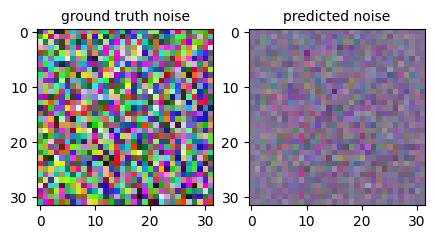

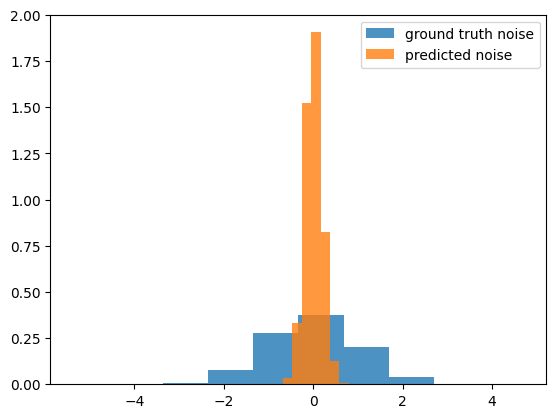

---
Epoch: 400 | Train Loss 0.008663563057780266


<Figure size 1500x1500 with 0 Axes>

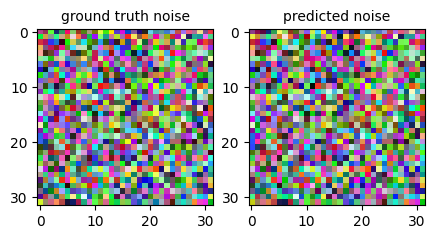

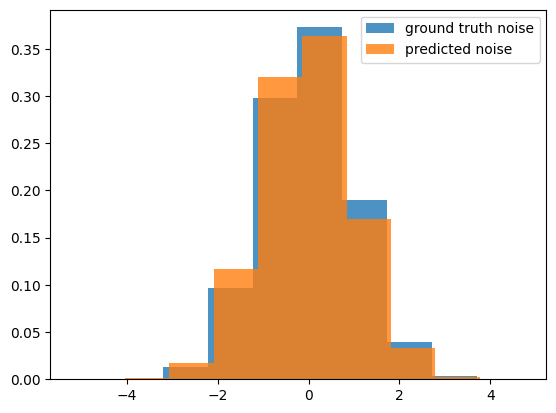

---
Epoch: 800 | Train Loss 0.0076757753267884254


<Figure size 1500x1500 with 0 Axes>

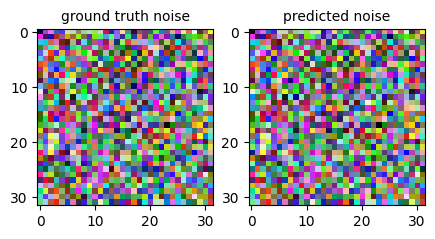

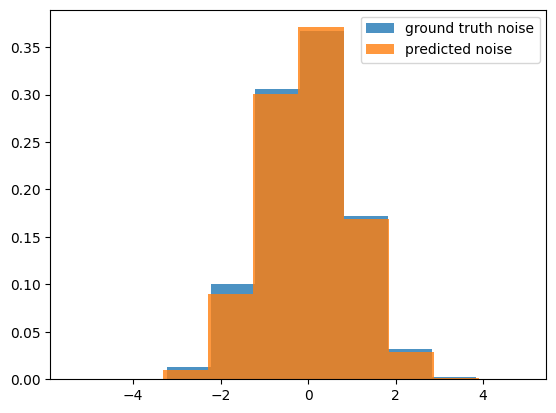

In [ ]:
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []

    batch = torch.stack([transformed_image] * BATCH_SIZE)
    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()

    batch_noisy, noise = forward_diffusion_sample(batch, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    predicted_noise = unet(batch_noisy, t)

    optimizer.zero_grad()
    loss = F.mse_loss(noise, predicted_noise)
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0].to(device), predicted_noise[0].to(device))
                plot_noise_distribution(noise, predicted_noise)


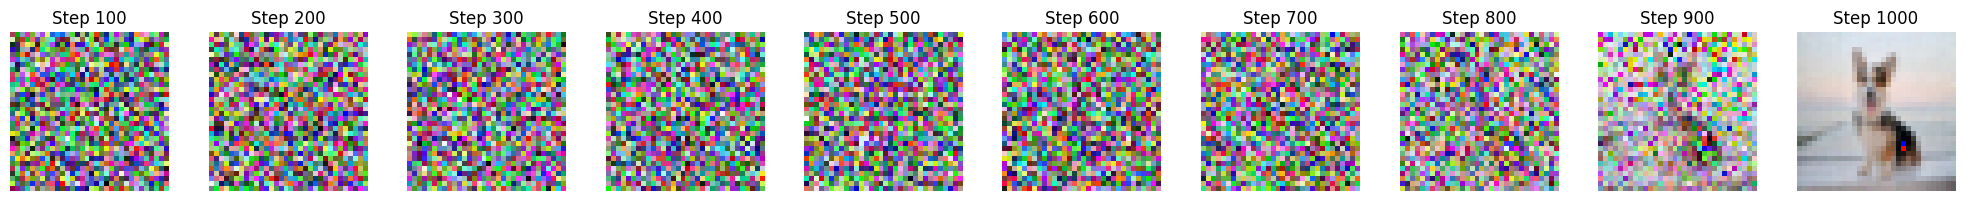

In [ ]:
import torch
import matplotlib.pyplot as plt

generated_images = []
show_every = 100

with torch.no_grad():
    img = torch.randn((1, 3) + IMAGE_SHAPE).to(device)
    unet.eval()

    for i in reversed(range(T)):
        t_tensor = torch.full((1,), i, dtype=torch.long, device=device)
        img = denoising_step(img, t_tensor, unet, alphas, alphas_cumprod, betas)

        if i % show_every == 0 or i == 0:  # Ensure final image is also included
            image_np = reverse_transform(img[0].cpu())
            generated_images.append((T - i, image_np))  # Keep track of step number

generated_images.sort()

fig, axes = plt.subplots(1, len(generated_images), figsize=(len(generated_images) * 2, 2))
if len(generated_images) == 1:
    axes = [axes]

for ax, (step, image) in zip(axes, generated_images):
    ax.imshow(image)
    ax.set_title(f"Step {step}")
    ax.axis("off")

plt.tight_layout()
plt.show()
